In [1]:
from osgeo import gdal
from gdalconst import *
import numpy as np
from glob import glob
import scipy
from scipy.stats import gaussian_kde
from os import path as osp
import os, subprocess
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def Z_ScoreNormalization(x,mu,sigma):
    x = (x - mu) / sigma;
    return x;
def MaxMinNormalization(x,Max,Min):
    x = (x - Min) / (Max - Min);
    return x;
def sigmoid(X,useStatus):
    if useStatus:
        #return 1.0 / (1 + np.exp(-float(X)))
        return 1.0 / (1 + np.exp(-X))
    else:
        return float(X)

In [3]:
def plot_tvdi(TVDI,shape_dir,outpath,label):
    #label是标题名称，字符串
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from mpl_toolkits.basemap import Basemap
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')
    import numpy as np
    
    #shape_dir = r'D:\wsy\Data\基础支持数据\矢量边界\\5province'
    lon_start = 110.
    lon_stop = 123.
    lat_start = 30.
    lat_stop = 43.
    lon_step = 0.1
    lat_step = 0.1

    xx = np.arange(lon_start, lon_stop, lon_step) 
    yy = np.arange(lat_start, lat_stop, lat_step)    
    lons, lats = np.meshgrid(xx,yy)

    plt.figure(figsize=(8,8))
    m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=43,llcrnrlon=110, urcrnrlon=123, suppress_ticks=True)
    parallels = np.arange(30, 43, 1)
    m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.25)
    meridians = np.arange(110., 123, 1)
    m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.25)

    # Plot TVDI
    
    m.readshapefile(shape_dir, 'limites', linewidth=2)
    TVDI_reverse = np.flipud(TVDI)
    max_v = np.nanmax(TVDI)
    min_v = np.nanmin(TVDI)
    cm = m.pcolormesh(lons,lats,TVDI_reverse,vmin = min_v, vmax = max_v, latlon=True, cmap='RdYlGn')
    cbar = m.colorbar(cm, location='right', pad="5%")
    #cbar.set_label('Z_score标准化后的SIF')
    cbar.set_label(label)
    plt.title('', fontsize=14)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    #plt.show()

In [4]:
sif_list = glob(r'D:\wsy\Data\SIF\TROPO\tiff\sgfilter\0.1\dcSIF\*.tif')

In [10]:
sif_list = sif_list[-1:]

1


c:\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
c:\python37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
c:\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
c:\python37\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
c:\python37\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
c:\python37\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
c:\python37\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWa

TROPO_SIF_2019-06-30  完成！


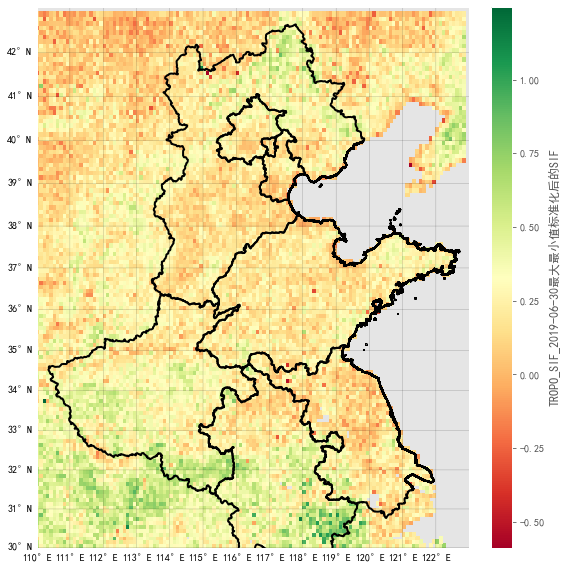

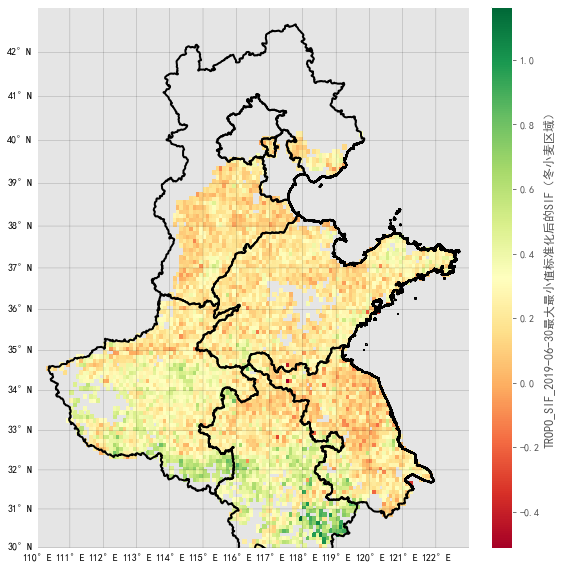

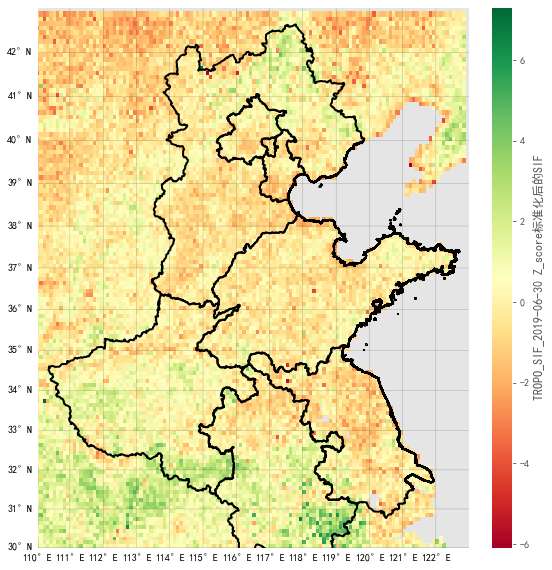

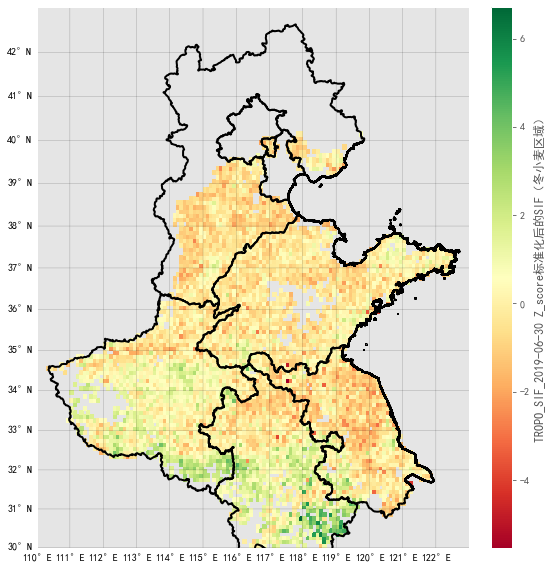

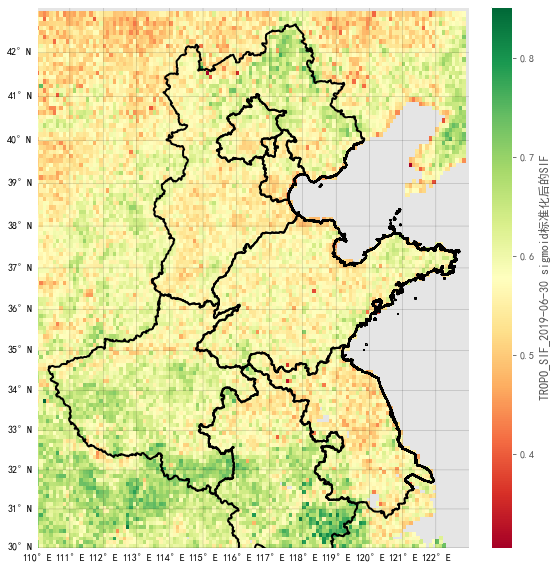

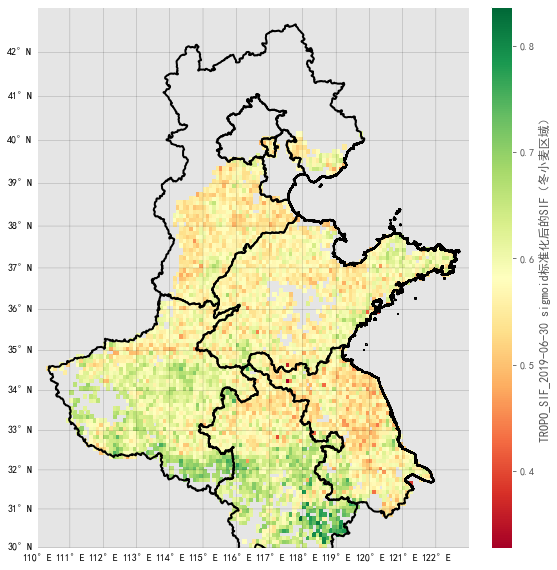

In [11]:

wheat = gdal.Open(r"D:\wsy\Data\SIF\zonal\sum_wheat.tif")
shape_dir = r'D:\wsy\Data\基础支持数据\矢量边界\\5province'
outdir = r'D:\wsy\Data\SIF\TROPO\tiff\sgfilter\0.1\dcSIF\normalization'
print(len(sif_list))
for file in sif_list:
    sifname = os.path.basename(file)[:20]
    
    sif = gdal.Open(file)
    sif_band = sif.GetRasterBand(1)
    gt = sif.GetGeoTransform()
    proj = sif.GetProjectionRef()
    dtype = sif_band.DataType
    sif_array = sif_band.ReadAsArray()

    wheat_band = wheat.GetRasterBand(1)
    wheat_array = wheat_band.ReadAsArray()
    wheat_index = np.where(wheat_array >= 5)
    
    sif_wheat_list = sif_array[wheat_index]
    sif_max = np.nanmax(sif_wheat_list)/10000.
    sif_min = np.nanmin(sif_wheat_list[np.where(sif_wheat_list > 0)])/10000.
    sif_avg = np.average(sif_wheat_list[np.where(sif_wheat_list > 0)])/10000.
    sif_std = np.std(sif_wheat_list[np.where(sif_wheat_list > 0)])/10000.
    
    
    sif_Max_Min = MaxMinNormalization(sif_array/10000.,sif_max,sif_min)
    sif_Z_score = Z_ScoreNormalization(sif_array/10000.,sif_avg,sif_std)
    sif_sigmoid = sigmoid(sif_array/10000.,1)
    
    cols = sif_array.shape[1]
    rows = sif_array.shape[0]
    
    # 全部区域进行最大最小值归一化的sif
    outFolder = outdir+'\\Max_Min\\all\\'
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    outpath = outFolder+sifname+'_normalization_Max_Min_all.tif'
    driver      = gdal.GetDriverByName('GTiff')
    dset_output = driver.Create(outpath,cols, rows, 1, gdal.GDT_Float64)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(sif_Max_Min)
    del dset_output
    label = sifname+'最大最小值标准化后的SIF'
    outpath = outpath.replace('.tif','.png')
    plot_tvdi(sif_Max_Min,shape_dir,outpath,label)
    
    # 冬小麦区域进行最大最小值归一化的sif
    sif_Max_Min[np.where(wheat_array < 1)] = np.nan
    outFolder = outdir+'\\Max_Min\\wheat\\'
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    outpath = outFolder+sifname+'_normalization_Max_Min_wheat.tif'
    driver      = gdal.GetDriverByName('GTiff')
    dset_output = driver.Create(outpath,cols, rows, 1, gdal.GDT_Float64)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(sif_Max_Min)
    del dset_output
    label = sifname+'最大最小值标准化后的SIF（冬小麦区域）'
    outpath =outpath.replace('.tif','.png')
    plot_tvdi(sif_Max_Min,shape_dir,outpath,label)
    
    # 全部区域进行Z_score归一化的sif
    outFolder = outdir+'\\Z_score\\all\\'
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    outpath = outFolder+sifname+'_normalization_Z_score_all.tif'
    driver      = gdal.GetDriverByName('GTiff')
    dset_output = driver.Create(outpath,cols, rows, 1, gdal.GDT_Float64)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(sif_Z_score)
    del dset_output
    label = sifname+' Z_score标准化后的SIF'
    outpath =outpath.replace('.tif','.png')
    plot_tvdi(sif_Z_score,shape_dir,outpath,label)
    
    # 冬小麦区域进行Z_score归一化的sif
    sif_Z_score[np.where(wheat_array < 1)] = np.nan
    outFolder = outdir+'\\Z_score\\wheat\\'
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    outpath = outFolder+sifname+'_normalization_Z_score_wheat.tif'
    driver      = gdal.GetDriverByName('GTiff')
    dset_output = driver.Create(outpath,cols, rows, 1, gdal.GDT_Float64)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(sif_Z_score)
    del dset_output
    label = sifname+' Z_score标准化后的SIF（冬小麦区域）'
    outpath =outpath.replace('.tif','.png')
    plot_tvdi(sif_Z_score,shape_dir,outpath,label)
    
    # 全部区域进行sigmoid归一化的sif
    outFolder = outdir+'\\sigmoid\\all\\'
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    outpath = outFolder+sifname+'_normalization_sigmoid_all.tif'
    driver      = gdal.GetDriverByName('GTiff')
    dset_output = driver.Create(outpath,cols, rows, 1, gdal.GDT_Float64)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(sif_sigmoid)
    del dset_output
    label = sifname+' sigmoid标准化后的SIF'
    outpath =outpath.replace('.tif','.png')
    plot_tvdi(sif_sigmoid,shape_dir,outpath,label)
    
    # 冬小麦区域进行sigmoid归一化的sif
    sif_sigmoid[np.where(wheat_array < 1)] = np.nan
    outFolder = outdir+'\\sigmoid\\wheat\\'
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    outpath = outFolder+sifname+'_normalization_sigmoid_wheat.tif'
    driver      = gdal.GetDriverByName('GTiff')
    dset_output = driver.Create(outpath,cols, rows, 1, gdal.GDT_Float64)
    dset_output.SetGeoTransform(gt)
    dset_output.SetProjection(proj)
    dset_output.GetRasterBand(1).WriteArray(sif_sigmoid)
    del dset_output
    label = sifname+' sigmoid标准化后的SIF（冬小麦区域）'
    outpath =outpath.replace('.tif','.png')
    plot_tvdi(sif_sigmoid,shape_dir,outpath,label)
    
    print(sifname+'  完成！')
    #break

In [12]:
def TimeToDoy(time):
    #输入格式为'2019-05-30'，输出为年和年积日
    from datetime import datetime
    fmt = "%Y-%m-%d"
    t = datetime.strptime(time,fmt)
    tt = t.timetuple()
    return tt.tm_year,tt.tm_yday
 
def DoyToTime(time):
    #输入格式为'2019-150'，输出为年月日
    from datetime import datetime
    fmt = "%Y-%j"
    t = datetime.strptime(time,fmt).date()
    fmt = "%Y-%m-%d"
    return t.strftime(fmt)

print(TimeToDoy('2019-05-30'))
print(DoyToTime('2019-150'))

(2019, 150)
2019-05-30


In [17]:
from glob import glob 
filelist = glob(r'D:\wsy\Data\SIF\TROPO\TVDI\ndvi_tvdi\*tif')
MOD_datelist = []
DOY_datelist = []

In [15]:
file = filelist[0]
data = file[46:53]
print(data)

2018241


In [19]:
for file in filelist:
    date = file[46:53]
    Year = date[:4]
    DOY = date[4:]
    time = str(Year)+'-'+str(DOY)
    MOD_date = str(DoyToTime(time))
    MOD_datelist.append(MOD_date)
    DOY_datelist.append(str(date))
for i in range(len(filelist)):
    print(DOY_datelist[i],MOD_datelist[i])


2018241 2018-08-29
2018249 2018-09-06
2018257 2018-09-14
2018265 2018-09-22
2018273 2018-09-30
2018281 2018-10-08
2018289 2018-10-16
2018297 2018-10-24
2018305 2018-11-01
2018313 2018-11-09
2018321 2018-11-17
2018329 2018-11-25
2018337 2018-12-03
2018345 2018-12-11
2018353 2018-12-19
2018361 2018-12-27
2019001 2019-01-01
2019009 2019-01-09
2019017 2019-01-17
2019025 2019-01-25
2019033 2019-02-02
2019041 2019-02-10
2019049 2019-02-18
2019057 2019-02-26
2019065 2019-03-06
2019073 2019-03-14
2019081 2019-03-22
2019089 2019-03-30
2019097 2019-04-07
2019105 2019-04-15
2019113 2019-04-23
2019121 2019-05-01
2019129 2019-05-09
2019137 2019-05-17
2019145 2019-05-25
2019153 2019-06-02
2019161 2019-06-10
2019169 2019-06-18
2019177 2019-06-26
2019185 2019-07-04
2019193 2019-07-12
